In [90]:
import itertools 
import string

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

import umap.umap_ as umap
import sklearn

from ripser import ripser, Rips
from persim import plot_diagrams

from nltk.tokenize import WordPunctTokenizer
from IPython.display import clear_output  

In [95]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

In [91]:
output_notebook()

def draw_vectors(x, y, radius = 10, alpha = 0.25, color = 'blue', 
                 width = 600, height = 400, show = True, **kwargs):
  if isinstance(color, str): color = [color]*len(x)
  data_source = bm.ColumnDataSource({'x' : x, 'y' : y, 'color':color, **kwargs})

  fig = pl.figure(active_scroll='wheel_zoom', width = width, height = height)
  fig.scatter('x', 'y', size = radius, color = 'color', alpha = alpha, source = data_source)

  fig.add_tools(bm.HoverTool(tooltips = [(key, "@"+key) for key in kwargs.keys()]))
  if show: pl.show(fig)
  return fig

Loading BokehJS ...

In [92]:
data = pd.read_csv('wiki_movie_plots_deduped.csv')
data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [96]:
data['Genre'].value_counts()[:4]

Genre
unknown    6083
drama      5964
comedy     4379
horror     1167
Name: count, dtype: int64

In [99]:
unknown_idx = np.array(data.index[data['Genre']=='unknown'])
dram_idx = np.array(data.index[data['Genre']=='drama'])
com_idx = np.array(data.index[data['Genre']=='comedy'])

tokenizer = WordPunctTokenizer()

In [105]:
def to_embed(_idx):
    _plots = data['Plot'][_idx]
    _tok = [tokenizer.tokenize(sentence.lower()) for sentence in _plots] 

    model = Word2Vec(_tok,
                    vector_size = 32,     #embedding vector size
                    min_count = 5, #consider words that occured at least 5 times 
                    window = 5).wv #define context s a 5-word window around the target word 

    words = sorted(model.index_to_key,
                key = lambda word : model.get_vecattr(word, "count"),
                reverse=True)[:1000]

    word_vectors = np.array([model.get_vector(word) for word in words])

    pca = PCA(3)
    scaler = StandardScaler() 

    word_vectors_pca = pca.fit_transform(word_vectors)
    word_vectors_pca = scaler.fit_transform(word_vectors_pca)

    _embedding = umap.UMAP(n_neighbors=5).fit_transform(word_vectors_pca)
    return _embedding, words

drama_embedding, drama_words  = to_embed(dram_idx)
com_embedding, com_words  = to_embed(com_idx)
draw_vectors(drama_embedding[:, 0], drama_embedding[:, 1], token = drama_words)
draw_vectors(com_embedding[:, 0], com_embedding[:, 1], token = com_words)

figure(id='p1497', ...)

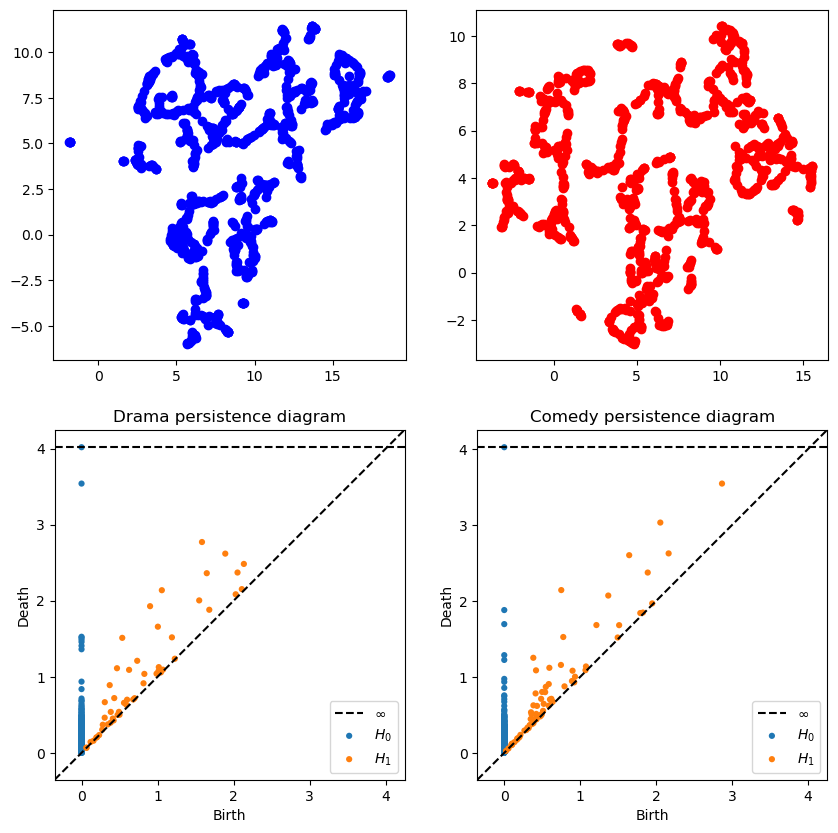

In [121]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0, 0].scatter(drama_embedding[:, 0], drama_embedding[:, 1], color = 'b')
ax[0, 1].scatter(com_embedding[:, 0], com_embedding[:, 1], color = 'r')

drama_dgms = ripser(drama_embedding)['dgms']
com_dgms = ripser(com_embedding)['dgms']

plt.subplot(223)
plot_diagrams(drama_dgms)
plt.title("Drama persistence diagram")
plt.subplot(224)
plot_diagrams(com_dgms)
plt.title("Comedy persistence diagram")
plt.show()